In [ ]:
from dolfinx import mesh, fem, io, plot
from dolfinx.common import Timer
from dolfinx.fem.petsc import LinearProblem
from ufl import (Identity, Measure, PermutationSymbol,
                nabla_grad, tr, TrialFunctions, TestFunctions,  
                dot, inner, sym, dx)
from basix.ufl import element, mixed_element
from petsc4py.PETSc import ScalarType   
from mpi4py import MPI
import numpy as np
import pyvista as pv

### Parameters

In [2]:
# units are in N, tonn, mm, s, mJ
Nx = 1 # Ny = Nx = Nz/3, number of cells in x direction
Nz = 15
a_x = 1.5e-4  # cell costant for x,y
a_z = 2/3 * a_x  # cell costant for z
perc_displ = 0.01
nu = -0.125 # Poisson's ratio
G = 0.1 # shear modulus G
l = 5*a_x  # intrinsic length scale
N = 0.93 # coupling parameter

In [ ]:
λ = G*((2*nu)/(1-2*nu))
μ =  G*((1-2*N**2)/(1-N**2))
# Computing COSSERAT constants
γ = 4*G*l**2
κ = G*((2*N**2)/(1-N**2))
# Micropolar elastic constants
α = ( μ * N**2 ) / (N**2 -1.0)
β = μ * l

### Strain and torsion

Strain components : $$\epsilon_{kl} = u_{l,k} - \varepsilon_{klm} \, \phi_m $$ 
where   $\varepsilon_{klm}$   is Levi-Civita symbol



Curvature (torsion) tensor: $$ \chi_{kl} = \phi_{l,k} $$


In [ ]:
E_3 = PermutationSymbol(3)
ϵ = lambda v, η: nabla_grad(v) - dot(E_3, η)
ϕ = lambda η: nabla_grad(η)

### Stress and couple stress


Stress tensor
$$ \sigma_{kl} = \lambda \, \epsilon_{rr} \, \delta_{kl} + (\mu + \kappa) \, \epsilon_{kl} + \mu \, \epsilon_{lk} $$

Couple tensor
$$ m_{kl} = \alpha \chi_{rr} \delta_{kl} + \beta \chi_{lk} + \gamma \chi_{kl} $$


In [ ]:
I3 =Identity(3)
σ = lambda λ, μ, κ, ϵ : λ * tr(ϵ) * I3 + (μ + κ) * ϵ + μ * ϵ.T
m_R= lambda α, β, γ, χ: α*tr(χ)*I3 +β*χ.T + γ*χ

### Mesh (box)
Two meshes are provided, just run the one you are interested in 

In [8]:
# box mesh
msh  = mesh.create_box(
comm=MPI.COMM_WORLD, 
points=([np.array([0, 0,0]),np.array([L:=Nx*a_x, L,  H:=Nz*a_z])]),
n= (5,5,20),
cell_type= mesh.CellType.hexahedron         
)

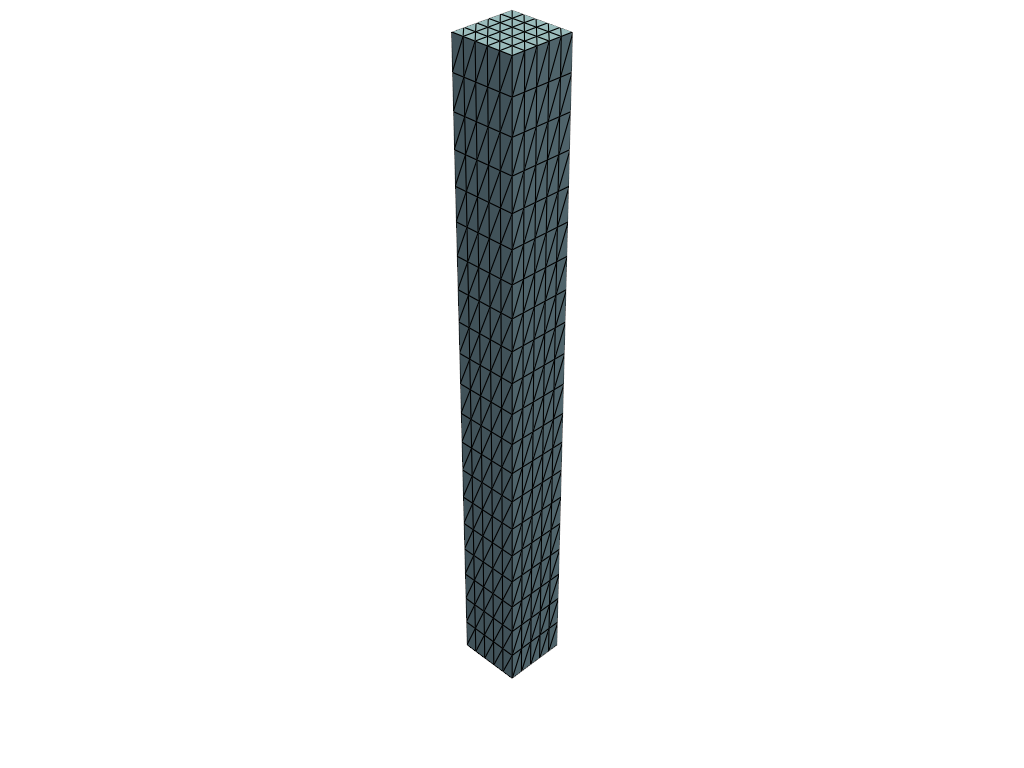

In [9]:
# displaying box mesh
cells, types, x = plot.vtk_mesh(msh)
grid = pv.UnstructuredGrid(cells, types, x)
plotter = pv.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.show()

In [10]:
boundaries = [(1, lambda x: np.isclose(x[2], 0)),
            (2, lambda x: np.isclose(x[2],H))]

facet_indices, facet_markers = [], []
fdim = msh.topology.dim - 1

for (marker, locator) in boundaries:
    facets = mesh.locate_entities(msh, fdim, locator)
    facet_indices = np.append(facet_indices, facets)
    facet_markers = np.append(facet_markers, np.full_like(facets, marker))
    facet_indices = np.hstack(facet_indices).astype(np.int32)
    facet_markers = np.hstack(facet_markers).astype(np.int32)
    sorted_facets = np.argsort(facet_indices)
    facet_tag = mesh.meshtags(msh, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])


### Mesh (cylinder)

In [ ]:
# cylindrical mesh
import gmsh
gmsh.initialize()

cylinder = gmsh.model.occ.addCylinder(0, 0, 0, 0, 0, H:=2*Nx*a_x, L:= H/2)
gmsh.model.occ.synchronize()
gdim = 3

gmsh.model.addPhysicalGroup(gdim, [cylinder], 1)
gmsh.model.addPhysicalGroup(gdim - 1, [cylinder], 2)

gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 1e-4)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 1e-4)
gmsh.model.mesh.generate(gdim)

gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD
msh, cell_markers, facet_markers = io.gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)

cells, types, x = plot.vtk_mesh(msh)
grid = pv.UnstructuredGrid(cells, types, x)
plotter = pv.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.show()


### Function spaces 

In [ ]:
# Function Space
dim = msh.geometry.dim
V_el = element("Lagrange", msh.topology.cell_name(), 1, shape=(dim,)) # displacement space
W_el = element("Lagrange", msh.topology.cell_name(), 2, shape=(dim,)) # micro rotation space
VW_element = mixed_element([V_el, W_el]) # dim 6
V = fem.functionspace(msh, VW_element) # mixed function space
# Extracting subspaces for displacement and micro-rotation    
V0,_ = V.sub(0).collapse()
V1,_ = V.sub(1).collapse() 

In [ ]:
u, θ = TrialFunctions(V)
v, η = TestFunctions(V)

### Boundary conditions

For $z = 0$ we have $(u, v, z)= (0,0,0)$  and $(\theta_1, \theta_2, \theta_3) = (0,0,0)$ and for $z = H$ we apply a fixed displacement such as $H_f = H - x*H$, where $x$ = `perc_displ`, if the forcing term is not zero we don't need the last bc.


In [13]:
facets_dim = msh.topology.dim - 1

boundary_facets = mesh.locate_entities_boundary(
    msh = msh,
    dim= facets_dim, 
    marker=lambda x: np.isclose(x[2], 0.0) 
    )

In [14]:
boundary_facets_z = mesh.locate_entities_boundary(
    msh = msh,
    dim= facets_dim, 
    marker=lambda x: np.isclose(x[2], H) 
    )

In [ ]:
dofs = fem.locate_dofs_topological(V=(V.sub(0), V0),entity_dim=facets_dim,entities=boundary_facets)
dofs_rot = fem.locate_dofs_topological(V=(V.sub(1), V1),entity_dim=facets_dim,entities=boundary_facets)
dofs_z = fem.locate_dofs_topological(V=(V.sub(0), V0),entity_dim=facets_dim,entities=boundary_facets_z) 
dofs_z_rot = fem.locate_dofs_topological(V=(V.sub(1), V1),entity_dim=facets_dim,entities=boundary_facets_z)

In [ ]:
# interpolation of the boundary conditions for the displacement 
fixed_displ_expr= lambda x: np.zeros((3, x.shape[1]), dtype=ScalarType)
fixed_displ = fem.Function(V0)
fixed_displ.interpolate(fixed_displ_expr)
# interpolation of the boundary conditions for the micro rotation
fixed_rot_expr= lambda x: np.zeros((3, x.shape[1]), dtype=ScalarType)
fixed_rot = fem.Function(V1)
fixed_rot.interpolate(fixed_rot_expr)

In [ ]:
# fixing displacement along the z axis for z=H, instead of applying a forcing term
def z_displ_expr(x):
    values = np.zeros((3, x.shape[1]), dtype=np.float64)
    values[2] = -perc_displ*H
    return values

fixed_displ_z = fem.Function(V0)
fixed_displ_z.interpolate(z_displ_expr)

def z_rot_expr(x):
    values = np.zeros((3, x.shape[1]), dtype=np.float64)
    return values

fixed_rot_z = fem.Function(V1)
fixed_rot_z.interpolate(z_rot_expr)

In [ ]:

bc_displ = fem.dirichletbc(value=fixed_displ,dofs=dofs,V=V.sub(0))
bc_displ_z = fem.dirichletbc(value=fixed_displ_z,dofs=dofs_z,V=V.sub(0)) 
bc_rot = fem.dirichletbc(value=fixed_rot,dofs=dofs_rot,V=V.sub(1))
# If you want to fix rotation on the top facet add this to bcs list
bc_rot_z = fem.dirichletbc(value=fixed_rot_z,dofs=dofs_z_rot,V=V.sub(1))

bcs= [bc_displ, bc_rot, bc_displ_z] 

### Variational formulation
Complete weak form for 3D Cosserat problem:
$$
\begin{equation}
\iiint_V \left( \sigma_{ij} \, \epsilon_{ij} + m_{ij} \, \chi_{ij} \right) \, dV = 
\iint_S \left( t_i \, u_i + Q_i \, \phi_i \right) \, dS + 
\iiint_V \left( p_i \, u_i + q_i \, \phi_i \right) \, dV
\end{equation}
$$
where t is the traction vector, Q is the couple vector, p is the body force vector and q is the body
moment vector.

In [ ]:

ds = Measure("ds", domain=msh, subdomain_data=facet_tag)

ϵ_u = ϵ(u, θ)
ϵ_v = ϵ(v, η)
χ_u = ϕ(θ)
χ_v = ϕ(η)
σ_u = σ(λ, μ, κ, ϵ_u)
σ_v = σ(λ, μ, κ, ϵ_v)
m_u = m_R(α, β, γ, χ_u)
m_v = m_R(α, β, γ, χ_v)
forcing_components = ScalarType((0.0, 0.0, 0.0))
traction_components = ScalarType((0.0, 0.0, 0.0))
forcing = fem.Constant(msh,forcing_components)
t = fem.Constant(msh, traction_components)
# if the forcing term is not null, the displacement along the z axis is not fixed and removed\\
# and removed from the list of boundary conditions
if (forcing_components != ScalarType((0.0, 0.0, 0.0))).any():
    bcs.remove(bc_displ_z)
if (traction_components != ScalarType((0.0, 0.0, 0.0))).any():
    bcs.remove(bc_displ_z)
a = inner(ϵ_v, σ_u)*dx + inner(χ_v, m_u)*dx
L = inner(t, v)*ds(2) + inner(forcing,v) * dx
U_h = fem.Function(V)
problem = LinearProblem(
                        a=a, 
                        L = L,
                        bcs= bcs,
                        u= U_h,
                        petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
                        )

# Solve the problem
with Timer() as t:
    problem.solve()
    print(f"Elapsed time: {t.elapsed()}")

u_h, θ_h = U_h.sub(0).collapse(), U_h.sub(1).collapse()
u_h.name = 'displacement'
θ_h.name = 'micro_rotation'

Elapsed time: [5.680000000000001, 5.54, 0.17]
5.364951563943431e-08
3.6316514615522387e-06


### Displaying solutions

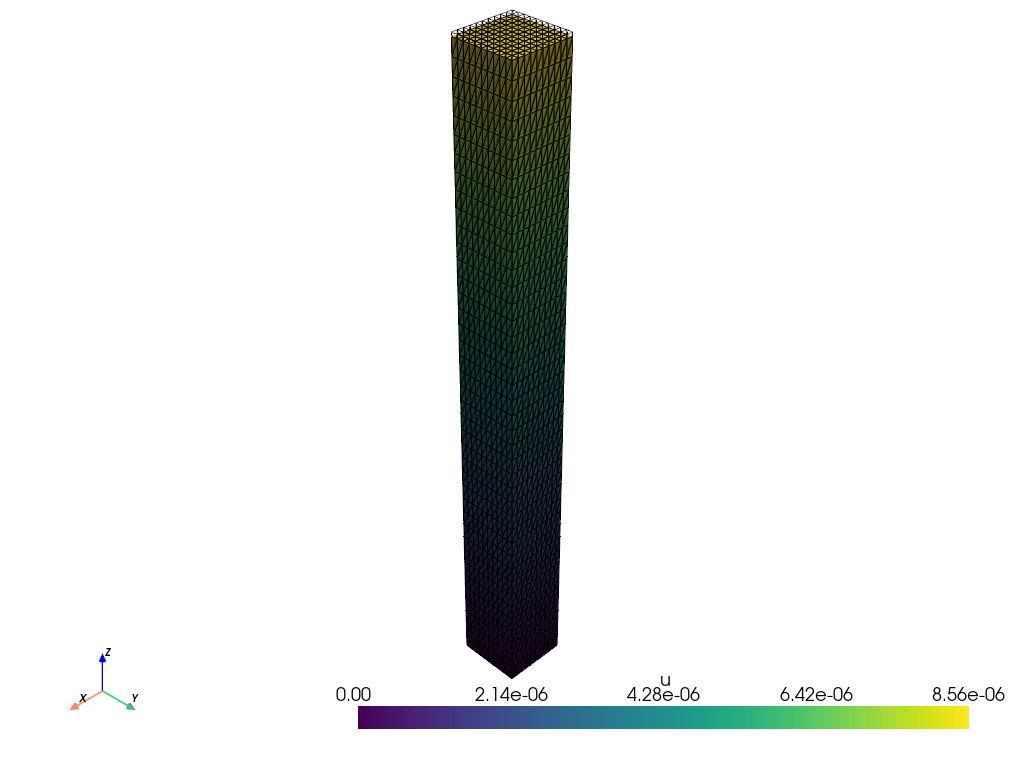

In [20]:
p = pv.Plotter()
topology, cell_types, geometry = plot.vtk_mesh(V0)
grid = pv.UnstructuredGrid(topology, cell_types, geometry)
grid["u"] = u_h.x.array.reshape(geometry.shape[0], 3)
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1)
actor_1 = p.add_mesh(warped, show_edges=True)
p.show_axes()
if not pv.OFF_SCREEN:
    p.show()

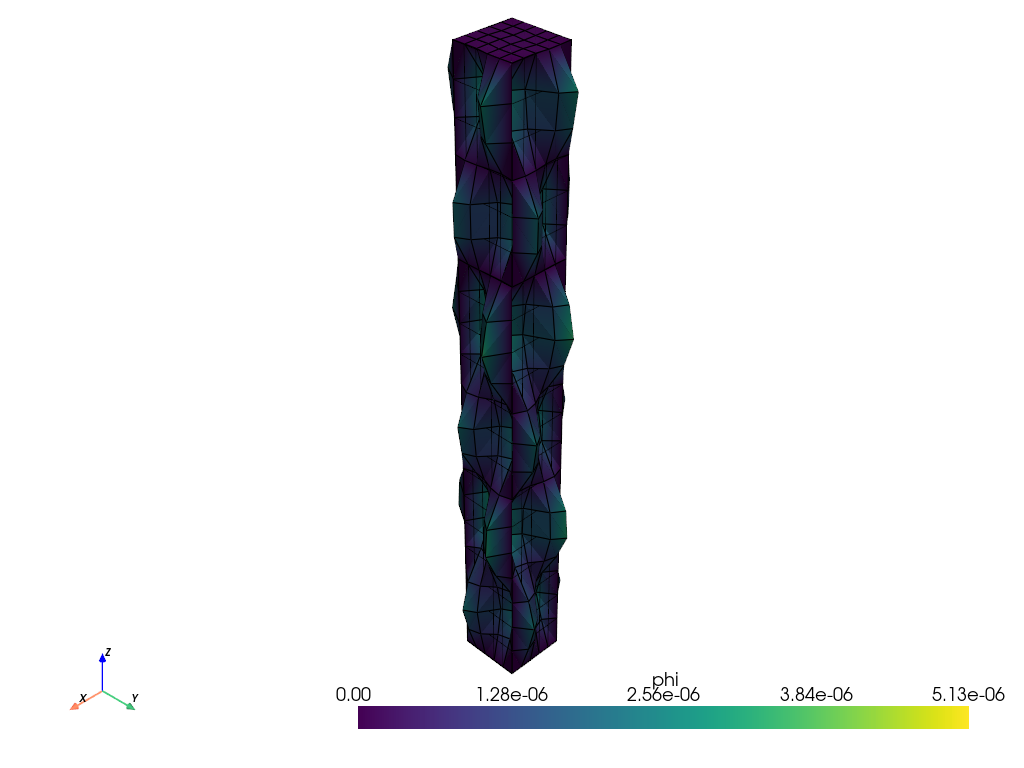

In [ ]:
p = pv.Plotter()
topology, cell_types, geometry = plot.vtk_mesh(V1)
grid = pv.UnstructuredGrid(topology, cell_types, geometry)
grid["theta"] = θ_h.x.array.reshape(geometry.shape[0], 3)
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("theta", factor=1e2)
actor_1 = p.add_mesh(warped, show_edges=True)
p.show_axes()
if not pv.OFF_SCREEN:
    p.show()

In [ ]:
# function to store both displacement and micro-rotation
total_displ = fem.Function(V1)
space = V1  # FunctionSpace for plotting id V_el.degree >= W_el.degree
if V_el.degree == W_el.degree:
    U_values = u_h.x.array + θ_h.x.array  # adding values 
elif V_el.degree > W_el.degree:
    # interpolating the higher degree element over the lower one
    displ_expr = fem.Expression(u_h, V1.element.interpolation_points())
    displ = fem.Function(V1)
    displ.interpolate(displ_expr)
    U_values = displ.x.array + θ_h.x.array
else:
    space = V0  # changing the function space if V_el < W_el
    # interpolating the higher degree element over the lower one
    total_displ = fem.Function(V0)
    rot_expr = fem.Expression(θ_h, V0.element.interpolation_points())
    rot = fem.Function(V0)
    rot.interpolate(rot_expr)
    U_values = u_h.x.array + rot.x.array

total_displ.name = 'combined_displacement'
total_displ.x.array[:] = U_values  # assigning values to the function

In [ ]:
# Displaying displacement and rotations togheter
p = pv.Plotter()
topology, cell_types, geometry = plot.vtk_mesh(space)
grid = pv.UnstructuredGrid(topology, cell_types, geometry)
grid["U"] = U_values.reshape(geometry.shape[0], 3)
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("U", factor=1)
actor_1 = p.add_mesh(warped, show_edges=True)
p.show_axes()

### von Mises Stress

In [ ]:
from ufl import sqrt
ϵ_uh = ϵ(u_h, θ_h)  # micropolar strain
σ_uh = σ(λ, μ, κ, ϵ_uh)  # stress tensor

deviatoric_stress_tensor = (σ_uh - 1/3 * tr(σ_uh) * Identity(2))
von_Mises_stress = sqrt(3/2 * inner(deviatoric_stress_tensor, deviatoric_stress_tensor))

Von_Mises_space = fem.functionspace(msh, ("DG", 0))
stress_expr = fem.Expression(von_Mises_stress, Von_Mises_space .element.interpolation_points())
stresses = fem.Function(stress_expr)
stresses.interpolate(stress_expr)

In [ ]:
warped = grid.warp_by_scalar("", factor=1)
warped.cell_data["VonMises"] = stresses.x.petsc_vec.array
warped.set_active_scalars("VonMises")
p = pv.Plotter()
p.add_mesh(warped)
p.show_axes()
if not pv.OFF_SCREEN:
    p.show()

### Saving solution to a .pvd file


In [ ]:
# get the notebook name to save the results in a way that 
# allows tracking which notebook generated each set of results.
from IPython import get_ipython
from os import path
notebook_name  = path.basename(get_ipython().get_parent()['metadata']['cellId'].split('/', 1)[1].split('.ipynb')[0])

In [ ]:
with io.VTKFile(MPI.COMM_WORLD, notebook_name + "/displacement_Nx" + str(Nx) + ".pvd", "w") as vtk:
    vtk.write_function(u_h, 0.0)  # 0.0 = time step

In [ ]:
with io.VTKFile(MPI.COMM_WORLD, notebook_name + "/micro_rotation_Nx" + str(Nx) + ".pvd", "w") as vtk:
    vtk.write_function(θ_h, 0.0)  # 0.0 = time step

In [ ]:
with io.VTKFile(MPI.COMM_WORLD, __file__.rstrip('.py') + "/u_Nx" + str(Nx) + ".pvd", "w") as vtk:
    vtk.write_function(total_displ, 0.0) # 0.0 = time step